# One-Shot Learning For File Type IdentificationClassifier with Classification-by-Retrieval
#### Ran Dubin and Amit Dvir, Ariel Cyber Innovation Center, Department of Computer Science, Ariel University, Israel
#### Chen Hajaj, Ariel Cyber Innovation Center Data Science and Artificial Intelligence Research Center Industrial Engineering and Management Department Ariel University, Israel
#### Ayelet Butman, Department of Computer Science Holon Institute of Technology, Israel



The paper used [1] dataset and export vectors from the FIFTY classification model as a feature extraction layer.
The FiFty dataset is divided into a smaller datasets. We used dataset number 1 to validate all possible file types.


[1] G. Mittal, P. Korus, and N. Memon, "FiFTy: Large-Scale File Fragment Type Identification Using Convolutional Neural Networks," in IEEE Transactions on Information Forensics and Security, vol. 16, pp. 28-41, 2021, doi: 10.1109/TIFS.2020.3004266.

[2] CT Medical Images, CT images from cancer imaging archive with contrast and patient age Link: https://www.kaggle.com/datasets/kmader/siim-medical-images?resource=download&select=dicom_dir

[3] Fifty models, code, https://github.com/mittalgovind/fifty


Install dependecies:

In [2]:
#Classification By Retrieval: # !pip install nmslib
#Extract layer output from Fifty model using Keract: !pip install keract

# Imports

In [1]:
import pandas as pd
import numpy as np
import os,sys
import nmslib
import time
import math
import pandas as pd
import multiprocessing

# Load Fifty Dataset

In [10]:
 def load_dataset(data_dir):
        """Loads relevant already prepared FFT-75 dataset"""
     
        train_data = np.load(os.path.join(data_dir, 'train.npz'), mmap_mode='r')
        x_train, y_train = train_data['x'], train_data['y']
        #one_hot_y_train = to_categorical(y_train)
        print("Training Data loaded with shape: {} and labels with shape - {}".format(x_train.shape,
                                                                                      y_train.shape))

        val_data = np.load(os.path.join(data_dir, 'val.npz'), mmap_mode='r')
        x_val, y_val = val_data['x'], val_data['y']
        #one_hot_y_val = to_categorical(y_val)
        print(
            "Validation Data loaded with shape: {} and labels with shape - {}".format(x_val.shape, y_val.shape))
        test_data = np.load(os.path.join(data_dir, 'test.npz'), mmap_mode='r')
        x_test, y_test = test_data['x'], test_data['y']
        #one_hot_y_test = to_categorical(y_val)
        print(
            "Validation Data loaded with shape: {} and labels with shape - {}".format(x_test.shape, y_test.shape))
        return x_train,y_train, x_val, y_val, x_test, y_test

In [ ]:
train_base_path = "/home/cyberlab/git/file-detector/dataset/512_1/" # note "512_1" and "4096_1" contains all the dataset classes.
X_train,y_train,X_val,y_val,X_test,y_test = load_dataset(train_base_path)

In [11]:
train_base_path = "/home/cyberlab/git/file-detector/dataset/4k_1/"
X_train,y_train,X_val,y_val,X_test,y_test = load_dataset(train_base_path)

Training Data loaded with shape: (6144000, 4096) and labels with shape - (6144000,)
Validation Data loaded with shape: (768000, 4096) and labels with shape - (768000,)
Validation Data loaded with shape: (768000, 4096) and labels with shape - (768000,)


In [4]:
len(X_train[0])

4096

In [12]:
y_train[0]

28

# Train the CBR model

In [6]:

M = 64 
efC = 100
print("number of cores:", multiprocessing.cpu_count())
num_threads = multiprocessing.cpu_count()
index_time_params = {'M': M, 'indexThreadQty': num_threads, 'efConstruction': efC, 'post': 0}
# Setting query-time parameters
efS = 1000 
query_time_params = {'efSearch': efS}

def train_zero_shot(features, df_labels, data_type, data_output):

    # Number of neighbors
    K = 100

    space_name = 'l2'

    # Intitialize the library, specify the space, the type of the vector and add data points
    # for l2
    index = nmslib.init(method='hnsw', space=space_name, data_type=nmslib.DataType.DENSE_VECTOR)
    index.addDataPointBatch(features)
    # Create an index
    start = time.time()
    index.createIndex(index_time_params, print_progress=True)
    end = time.time()
    print('Index-time parameters', index_time_params)
    print('Indexing time = %f' % (end - start))
    print('Setting query-time parameters', query_time_params)
    index.setQueryTimeParams(query_time_params)

    # Querying
    query_qty = len(features)
    start = time.time()
    nbrs = index.knnQueryBatch(features, k=K, num_threads=num_threads)
    end = time.time()
    print('kNN time total=%f (sec), per query=%f (sec), per query adjusted for thread number=%f (sec)' %
          (end - start, float(end - start) / query_qty, num_threads * float(end - start) / query_qty))
    print("save model")
    # Save a meta index and data
    name = data_type + ".bin"
    index_name = data_type + ".in"
    save_to = data_output + name
    save_to_in = data_output + index_name
    index.saveIndex(save_to, save_data=False)
    # save index labels
    df_labels[["index", "label"]].to_csv(save_to_in, sep=",")

number of cores: 16


In [7]:
train_base_path.split("/")[-2]

'512_1'

In [ ]:
#train_base_path = "/home/cyberlab/git/file-detector/dataset/512_1/"

data_type = "file_type_model_" + train_base_path.split("/")[-2]
data_output = "/home/cyberlab/git/file-detector/output/{}/".format(data_type)
train_zero_shot(X_train,y_train, data_type, data_output)


0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************


Index-time parameters {'M': 64, 'indexThreadQty': 16, 'efConstruction': 100, 'post': 0}
Indexing time = 5093.697850
Setting query-time parameters {'efSearch': 1000}


In [ ]:
def predict_zero_shot(features, df_labels, data_type, data_output):
    # Re-intitialize the library, specify the space, the type of the data and add data points
    # Note again that in the GENERIC case, data points are passed as strings!
    space_name = 'l2'
    newIndex = nmslib.init(method='hnsw', space=space_name, data_type=nmslib.DataType.DENSE_VECTOR)
    # Re-load the index and the data
    name = data_type + ".bin"
    load_path = data_output + name
    newIndex.loadIndex(load_path, load_data=False)
    # Setting query-time parameters and querying
    print('Setting query-time parameters', query_time_params)
    newIndex.setQueryTimeParams(query_time_params)

    t = 101
    K = 100
    features = features
    nbrs = newIndex.knnQueryBatch(features[t].reshape(1, -1), k=K, num_threads=num_threads)
    label_index = df_labels.loc[[t]]
    print("Search similar for to label:",label_index.get("index",""),"md5",label_index.get("md5",""),
          "sha1",label_index.get("sha1",""), "sha256",label_index.get("sha256",""),
                                       "sha512",label_index.get("sha512",""), "label_threat_cat",
                                        label_index.get("label_threat_cat",""), "label_threat_name",label_index.get("label_threat_name",""))
    black_rep = 0
    for i in range(0, len(nbrs[0][0])):
        print("i", i)
        record = df_labels[df_labels["index"]==nbrs[0][0][i]]
        print("md5: ", record.get("md5").values[0], "score:",1 - float(nbrs[0][1][i]) / max(nbrs[0][1]), "label:", record.get("label").values[0])
        if "1" == record.get("label").values[0]:
            black_rep += 1
    print("final verdict:", float(black_rep) /  K)


In [12]:
target_names = []
for i in range(0,75):
    target_names.append(str(i))

In [13]:
target_names

['0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 '10',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '18',
 '19',
 '20',
 '21',
 '22',
 '23',
 '24',
 '25',
 '26',
 '27',
 '28',
 '29',
 '30',
 '31',
 '32',
 '33',
 '34',
 '35',
 '36',
 '37',
 '38',
 '39',
 '40',
 '41',
 '42',
 '43',
 '44',
 '45',
 '46',
 '47',
 '48',
 '49',
 '50',
 '51',
 '52',
 '53',
 '54',
 '55',
 '56',
 '57',
 '58',
 '59',
 '60',
 '61',
 '62',
 '63',
 '64',
 '65',
 '66',
 '67',
 '68',
 '69',
 '70',
 '71',
 '72',
 '73',
 '74']

In [15]:
# load non original (layer to validate rf)
def load_dataset(data_dir):
    """Loads relevant already prepared FFT-75 dataset"""
    x = "arr_0" # x
    y = "arr_1" # y
    #train_data = np.load(os.path.join(data_dir, 'train_leaky_re_lu_3.npz'))
    train_data = np.load(os.path.join(data_dir, 'train_dense_2.npz'))

    x_train, y_train = train_data[x], train_data[y]
    x_new = []
    for val in x_train:
        x_new.append(val[0])
    x_train = np.array(x_new)
    # one_hot_y_train = to_categorical(y_train)
    print("Training Data loaded with shape: {} and labels with shape - {}".format(x_train.shape,
                                                                                  y_train.shape))
    x_new = []
    #val_data = np.load(os.path.join(data_dir, 'val_leaky_re_lu_3.npz'))
    val_data = np.load(os.path.join(data_dir, 'val_dense_2.npz'))
    x_val, y_val = val_data[x], val_data[y]
    print("orig x_val",x_val.shape)
    for val in x_val:
        x_new.append(val[0])
    x_val = np.array(x_new)
    # one_hot_y_val = to_categorical(y_val)
    print(
        "Validation Data loaded with shape: {} and labels with shape - {}".format(x_val.shape, y_val.shape))
    x_new = []
    #test_data = np.load(os.path.join(data_dir, 'test_leaky_re_lu_3.npz'))
    test_data = np.load(os.path.join(data_dir, 'test_dense_2.npz'))
    x_test, y_test = test_data[x], test_data[y]
    for val in x_test:
        x_new.append(val[0])
    x_test = np.array(x_new)
    # one_hot_y_test = to_categorical(y_val)
    print(
        "Validation Data loaded with shape: {} and labels with shape - {}".format(x_test.shape, y_test.shape))
    return x_train, y_train, x_val, y_val, x_test, y_test

# load features after we created them from the FiFty CNN model itself
train_base_path = "/home/cyberlab/git/file-detector/dataset/4k_1/CNN/"
X_train, y_train, X_val, y_val, X_test, y_test = load_dataset(train_base_path)

Training Data loaded with shape: (6144000, 75) and labels with shape - (6144000,)
orig x_val (768000, 1, 75)
Validation Data loaded with shape: (768000, 75) and labels with shape - (768000,)
Validation Data loaded with shape: (768000, 75) and labels with shape - (768000,)


In [3]:
# dense 2 comparison test with Random Forest
'''
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
# X_train,y_train,X_val,y_val,X_test,y_test
clf = RandomForestClassifier(max_depth=2, random_state=0,class_weight="balanced_subsample")
clf.fit(X_train, y_train)
predicted = clf.predict(X_test)
from sklearn.metrics import classification_report
#target_names = ["jpg", "arw", "cr2", "dng", "gpr", "nef", "nrw", "orf", "pef", "raf", "rw2", "3fr", "tiff", "heic", "bmp", "gif", "png", "ai", "eps", "psd", "mov", "mp4", "3gp", "avi", "mkv", "ogv", "webm", "apk", "jar", "msi", "dmg", "7z", "bz2", "deb", "gz", "pkg", "rar", "rpm", "xz", "zip", "exe", "mach-o", "elf", "dll", "doc", "docx", "key", "ppt", "pptx", "xls", "xlsx", "djvu", "epub", "mobi", "pdf", "md", "rtf", "txt", "tex", "json", "html", "xml", "log", "csv", "aiff", "flac", "m4a", "mp3", "ogg", "wav", "wma", "pcap", "ttf", "dwg", "sqlite"]
print(classification_report(y_test, predicted, target_names=target_names))
'''

'\nfrom sklearn.ensemble import RandomForestClassifier\nfrom sklearn.datasets import make_classification\n# X_train,y_train,X_val,y_val,X_test,y_test\nclf = RandomForestClassifier(max_depth=2, random_state=0,class_weight="balanced_subsample")\nclf.fit(X_train, y_train)\npredicted = clf.predict(X_test)\nfrom sklearn.metrics import classification_report\n#target_names = ["jpg", "arw", "cr2", "dng", "gpr", "nef", "nrw", "orf", "pef", "raf", "rw2", "3fr", "tiff", "heic", "bmp", "gif", "png", "ai", "eps", "psd", "mov", "mp4", "3gp", "avi", "mkv", "ogv", "webm", "apk", "jar", "msi", "dmg", "7z", "bz2", "deb", "gz", "pkg", "rar", "rpm", "xz", "zip", "exe", "mach-o", "elf", "dll", "doc", "docx", "key", "ppt", "pptx", "xls", "xlsx", "djvu", "epub", "mobi", "pdf", "md", "rtf", "txt", "tex", "json", "html", "xml", "log", "csv", "aiff", "flac", "m4a", "mp3", "ogg", "wav", "wma", "pcap", "ttf", "dwg", "sqlite"]\nprint(classification_report(y_test, predicted, target_names=target_names))\n'

Confusion metrix for the classification if we want.

In [ ]:
target_names = ["jpg", "arw", "cr2", "dng", "gpr", "nef", "nrw", "orf", "pef", "raf", "rw2", "3fr", "tiff", "heic", "bmp", "gif", "png", "ai", "eps", "psd", "mov", "mp4", "3gp", "avi", "mkv", "ogv", "webm", "apk", "jar", "msi", "dmg", "7z", "bz2", "deb", "gz", "pkg", "rar", "rpm", "xz", "zip", "exe", "mach-o", "elf", "dll", "doc", "docx", "key", "ppt", "pptx", "xls", "xlsx", "djvu", "epub", "mobi", "pdf", "md", "rtf", "txt", "tex", "json", "html", "xml", "log", "csv", "aiff", "flac", "m4a", "mp3", "ogg", "wav", "wma", "pcap", "ttf", "dwg", "sqlite"]

print(classification_report(y_test, predicted, target_names=target_names))

In [25]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, predicted, labels=target_names)

array([[  0, 381,   0, ...,   0,   0,  30],
       [  0, 682,   0, ...,   3,   0,  46],
       [  0, 329,   0, ...,   3,   0,  15],
       ...,
       [  0,  60,   0, ...,   7,   0,  52],
       [  0, 387,   0, ...,   6,   0,  65],
       [  0,  65,   0, ...,   0,   0,  57]])

# Load FiFty CNN model
For each data converstion and layer extraction please load the correct 512_1 or 4096_1 models.

In [43]:
from keras.models import load_model
#model_path = "/home/cyberlab/git/file-detector/fifty-models/4096_1.h5"
model_path = "/home/cyberlab/git/file-detector/fifty-models/512_1.h5"
model = load_model(model_path)

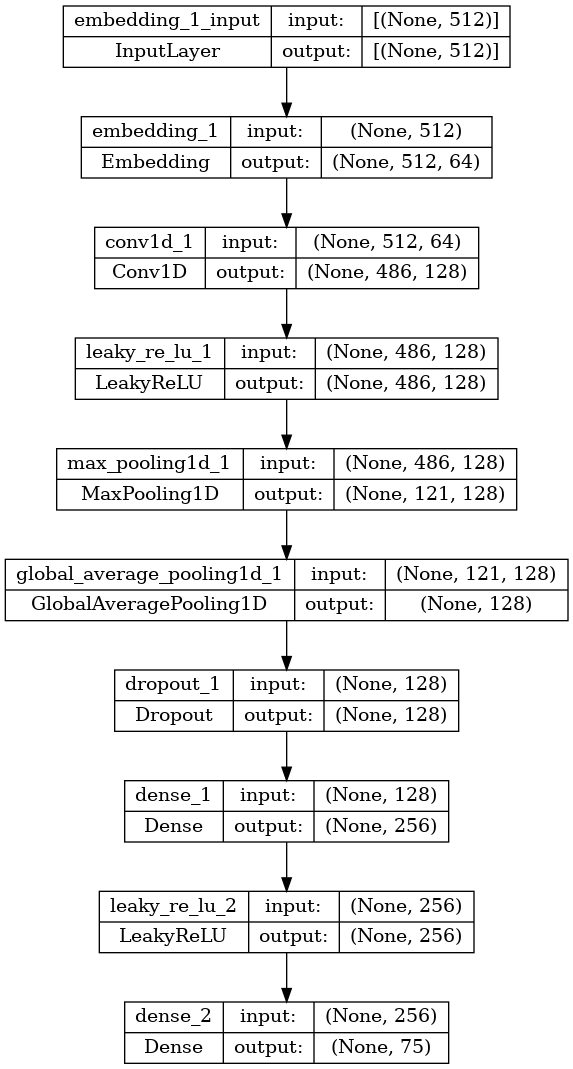

In [44]:
import tensorflow.compat.v2 as tf
dot_img_file = "/home/cyberlab/git/file-detector/cnn512.png"
tf.keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True)

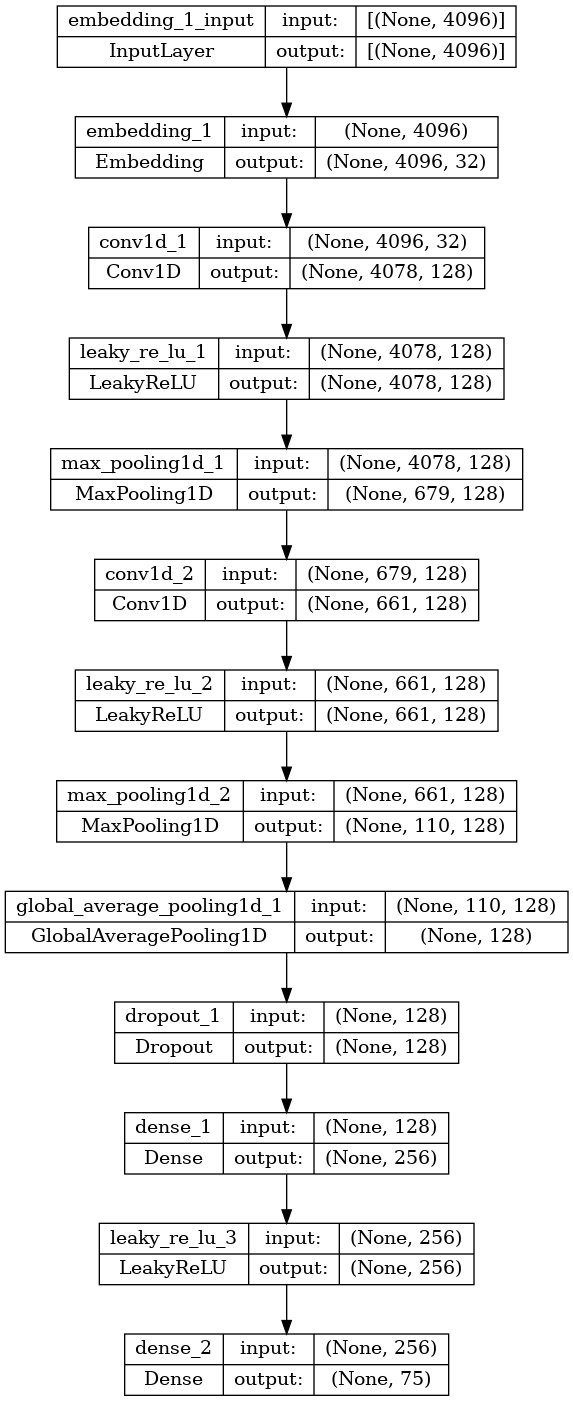

In [42]:
import tensorflow.compat.v2 as tf
dot_img_file = "/home/cyberlab/git/file-detector/cnn4096.png"
tf.keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True)

In [6]:
  model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 4096, 32)          8192      
                                                                 
 conv1d_1 (Conv1D)           (None, 4078, 128)         77952     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 4078, 128)         0         
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 679, 128)         0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 661, 128)          311424    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 661, 128)          0         
                                                      

In [20]:
X_train[0:10]

array([[  9, 167, 191, ...,  79, 115, 250],
       [243, 248, 239, ..., 115, 101, 166],
       [217, 219, 143, ..., 175, 149, 152],
       ...,
       [ 90, 240, 100, ..., 187, 217, 173],
       [106,  70, 152, ...,  86,  32, 232],
       [ 98, 119, 217, ..., 187, 131, 221]], dtype=uint8)

# Extract output layers from FiFty model using Keract
Note: this is done for 512 and 4096 and DICOM. We convert the Train, Test and Validation datasets.
Make sure you are working with the correct 512 or 4096 Fifty model.
Please change the output names accordingly.

## Train

In [ ]:


from keract import get_activations, persist_to_json_file, load_activations_from_json_file
new_X_train_leaky_re_lu_2 = []
new_X_train_dense_1 = []
new_X_train_dense_2 = []

for val in range(len(X_train)):
    activations = get_activations(model, X_train[val].reshape(1,-1))
    new_X_train_leaky_re_lu_2.append(activations['leaky_re_lu_3'])
    new_X_train_dense_1.append(activations['dense_1'])
    new_X_train_dense_2.append(activations['dense_2'])
    
np.savez("/home/cyberlab/git/file-detector/dataset/4k_1/CNN/train_leaky_re_lu_3.npz",new_X_train_leaky_re_lu_2,y_train)
np.savez("/home/cyberlab/git/file-detector/dataset/4k_1/CNN/train_dense_1.npz",new_X_train_dense_1,y_train)
np.savez("/home/cyberlab/git/file-detector/dataset/4k_1/CNN/train_dense_2.npz",new_X_train_dense_2,y_train)
#activations = get_activations(model, X_train)

## Test

In [8]:
new_X_test_leaky_re_lu_2 = []
new_X_test_dense_1 = []
new_X_test_dense_2 = []
for val in range(len(X_test)):
    activations = get_activations(model, X_test[val].reshape(1,-1))
    new_X_test_leaky_re_lu_2.append(activations['leaky_re_lu_3'])
    new_X_test_dense_1.append(activations['dense_1'])
    new_X_test_dense_2.append(activations['dense_2'])
np.savez("/home/cyberlab/git/file-detector/dataset/4k_1/CNN/test_leaky_re_lu_3.npz",new_X_test_leaky_re_lu_2,y_test)
np.savez("/home/cyberlab/git/file-detector/dataset/4k_1/CNN/test_dense_1.npz",new_X_test_dense_1,y_test)
np.savez("/home/cyberlab/git/file-detector/dataset/4k_1/CNN/test_dense_2.npz",new_X_test_dense_2,y_test)

## Validation

In [10]:
new_X_val_leaky_re_lu_2 = []
new_X_val_dense_1 = []
new_X_val_dense_2 =[]
for val in range(len(X_val)):
    activations = get_activations(model, X_val[val].reshape(1,-1))
    new_X_val_leaky_re_lu_2.append(activations['leaky_re_lu_3'])
    new_X_val_dense_1.append(activations['dense_1'])
    new_X_val_dense_2.append(activations['dense_2'])
np.savez("/home/cyberlab/git/file-detector/dataset/4k_1/CNN/val_leaky_re_lu_3.npz",new_X_val_leaky_re_lu_2,y_val)
np.savez("/home/cyberlab/git/file-detector/dataset/4k_1/CNN/val_dense_1.npz",new_X_val_dense_1,y_val)
np.savez("/home/cyberlab/git/file-detector/dataset/4k_1/CNN/val_dense_2.npz",new_X_val_dense_2,y_val)

# Load DICOM dataset

In [13]:
import os,sys

import re
import json
import pandas as pd
import numpy as np
import time
import shutil
from pathlib import Path
from pdb import set_trace
from keract import get_activations


def get_utilities_dir():
    return os.path.dirname(__file__)


def read_file(path, block_size):
    data = open(path, 'rb').read()
    if len(data) < block_size:
        print('Skipping {}. Smaller than one block size ({} bytes). Try smaller block size.'.format(path, block_size))
        return None
    bound = (len(data) // block_size) * block_size
    data = data[:bound]
    file = np.array(np.array(list(data), dtype=np.uint8).reshape((-1, block_size)))
    del data
    return file
def read_files(input, block_size, recursive):
    """Reads the data disk or folder for inference"""
    if os.path.isfile(input):
        file_block = read_file(input, block_size)
        if file_block is not None:
            yield file_block, os.path.split(input)[1]
    elif os.path.exists(input):
        if recursive:
            pattern = '**/*'
        else:
            pattern = './*'
        for path in Path(input).glob(pattern):
            if os.path.isfile(path):
                file_block = read_file(path, block_size)
                if file_block is not None:
                    try:
                        file_name = os.path.split(path)[1]
                    except:
                        file_name = 'non-alphanumeric-name.xyz'
                    yield file_block, file_name
    else:
        raise FileNotFoundError('Could not find {}'.format(input))

# Read the DICOM dataset save  the first 512/ 4096 following FIFTY dataset extraction steps.

In [23]:
The first 10 files are used to train the few shot/one shot the other 90 are used for testing CBR model.
#gen_files = read_files("/home/cyberlab/git/file-detector/dicom_dataset/",4096,False)
gen_files = read_files("/home/cyberlab/git/file-detector/dicom_dataset/",512,False)

In [24]:
import traceback

from keras.models import load_model
model_path = "/home/cyberlab/git/file-detector/fifty-models/512_1.h5"
#model_path = "/home/cyberlab/git/file-detector/fifty-models/4096_1.h5"
X_val = []
y_val = []
model = load_model(model_path)
output_predictions = []
detected_as = []
count = 0
while count <100:
    count +=1
    try:
        file, file_name = next(gen_files)
        #pred_probability  = model.predict_classes(file)
        X_val.append(file[0])
        y_val.append(76)
        pred_probability  = model.predict(file[0].reshape(1,-1))
        predict_classes=np.argmax(pred_probability,axis=1)
        print(predict_classes, file_name)
        detected_as.append(predict_classes[0])
        output_predictions.append({"predict_classes":predict_classes, "file_name":file_name})
        del file, file_name
    except:
        print("error")
        #Exception as e: 
        #print(e)
        #traceback.print_exc()
        
new_X_val_leaky_re_lu_2 = []
new_X_val_dense_1 = []
new_X_val_dense_2 =[]
for val in range(len(X_val)):
    activations = get_activations(model, X_val[val].reshape(1,-1))
    #new_X_val_leaky_re_lu_2.append(activations['leaky_re_lu_3']) # for 4096
    new_X_val_leaky_re_lu_2.append(activations['leaky_re_lu_2'])
    new_X_val_dense_1.append(activations['dense_1'])
    new_X_val_dense_2.append(activations['dense_2'])
#np.savez("/home/cyberlab/git/file-detector/dataset/4k_1/Dicom/val_leaky_re_lu_3.npz",new_X_val_leaky_re_lu_2,y_val)
#np.savez("/home/cyberlab/git/file-detector/dataset/4k_1/Dicom/val_dense_1.npz",new_X_val_dense_1,y_val)
#np.savez("/home/cyberlab/git/file-detector/dataset/4k_1/Dicom/val_dense_2.npz",new_X_val_dense_2,y_val)
np.savez("/home/cyberlab/git/file-detector/dataset/512_1/Dicom/val_leaky_re_lu_2.npz",new_X_val_leaky_re_lu_2,y_val)
np.savez("/home/cyberlab/git/file-detector/dataset/512_1/Dicom/val_dense_1.npz",new_X_val_dense_1,y_val)
np.savez("/home/cyberlab/git/file-detector/dataset/512_1/Dicom/val_dense_2.npz",new_X_val_dense_2,y_val)

1/1 [==============================] - 0s 38ms/step
[42] ID_0015_AGE_0061_CONTRAST_1_CT.dcm
1/1 [==============================] - 0s 10ms/step
[46] ID_0048_AGE_0077_CONTRAST_1_CT.dcm
1/1 [==============================] - 0s 10ms/step
[46] ID_0080_AGE_0070_CONTRAST_0_CT.dcm
1/1 [==============================] - 0s 9ms/step
[42] ID_0013_AGE_0060_CONTRAST_1_CT.dcm
1/1 [==============================] - 0s 9ms/step
[42] ID_0051_AGE_0063_CONTRAST_0_CT.dcm
1/1 [==============================] - 0s 10ms/step
[46] ID_0007_AGE_0061_CONTRAST_1_CT.dcm
1/1 [==============================] - 0s 10ms/step
[42] ID_0041_AGE_0045_CONTRAST_1_CT.dcm
1/1 [==============================] - 0s 11ms/step
[42] ID_0062_AGE_0067_CONTRAST_0_CT.dcm
1/1 [==============================] - 0s 10ms/step
[42] ID_0064_AGE_0058_CONTRAST_0_CT.dcm
1/1 [==============================] - 0s 10ms/step
[42] ID_0025_AGE_0074_CONTRAST_1_CT.dcm
1/1 [==============================] - 0s 10ms/step
[46] ID_0057_AGE_0049_CONTRAST

# Checking Classification By Retrevial result  without DICOM.

## Checking 4k dense 1

In [17]:
import pandas as pd
file_in = "/home/cyberlab/git/file-detector/output/file_type_cnn_4k_1_dense1_model_CNN/file_type_cnn_4k_1_dense1_model_CNN.in.csv"
df = pd.read_csv(file_in,sep=",")

In [18]:
df.columns

Index(['Unnamed: 0', 'index', 'label', 'predicted', 'score'], dtype='object')

In [19]:
from sklearn.metrics import classification_report
label = df[["label"]].values
pred = df[["predicted"]].values
target_names = ["jpg", "arw", "cr2", "dng", "gpr", "nef", "nrw", "orf", "pef", "raf", "rw2", "3fr", "tiff", "heic", "bmp", "gif", "png", "ai", "eps", "psd", "mov", "mp4", "3gp", "avi", "mkv", "ogv", "webm", "apk", "jar", "msi", "dmg", "7z", "bz2", "deb", "gz", "pkg", "rar", "rpm", "xz", "zip", "exe", "mach-o", "elf", "dll", "doc", "docx", "key", "ppt", "pptx", "xls", "xlsx", "djvu", "epub", "mobi", "pdf", "md", "rtf", "txt", "tex", "json", "html", "xml", "log", "csv", "aiff", "flac", "m4a", "mp3", "ogg", "wav", "wma", "pcap", "ttf", "dwg", "sqlite"]
print(classification_report(label, pred, target_names=target_names))

              precision    recall  f1-score   support

         jpg       0.92      0.92      0.92     10260
         arw       0.99      0.99      0.99     10204
         cr2       0.94      0.97      0.95     10328
         dng       0.87      0.96      0.91     10206
         gpr       1.00      1.00      1.00     10155
         nef       0.97      0.98      0.98     10444
         nrw       0.99      0.99      0.99     10459
         orf       0.96      0.97      0.97     10143
         pef       0.99      0.99      0.99     10263
         raf       0.96      0.95      0.96     10303
         rw2       0.99      0.98      0.98     10264
         3fr       1.00      1.00      1.00     10250
        tiff       0.98      0.99      0.99     10132
        heic       0.11      0.12      0.12     10308
         bmp       0.97      1.00      0.98     10289
         gif       0.98      0.99      0.99     10289
         png       0.89      0.85      0.87     10376
          ai       0.70    

## Checking 4k dense 2

              precision    recall  f1-score   support

         jpg       0.85      0.84      0.84     10260
         arw       0.99      0.99      0.99     10204
         cr2       0.93      0.93      0.93     10328
         dng       0.95      0.94      0.95     10206
         gpr       1.00      1.00      1.00     10155
         nef       0.95      0.95      0.95     10444
         nrw       0.97      0.97      0.97     10459
         orf       0.96      0.97      0.96     10143
         pef       0.98      0.98      0.98     10263
         raf       0.94      0.93      0.94     10303
         rw2       0.98      0.98      0.98     10264
         3fr       0.99      0.99      0.99     10250
        tiff       0.98      0.98      0.98     10132
        heic       0.11      0.11      0.11     10308
         bmp       0.98      0.99      0.98     10289
         gif       0.99      0.99      0.99     10289
         png       0.80      0.79      0.80     10376
          ai       0.57    

ValueError: The number of FixedLocator locations (25), usually from a call to set_ticks, does not match the number of ticklabels (75).

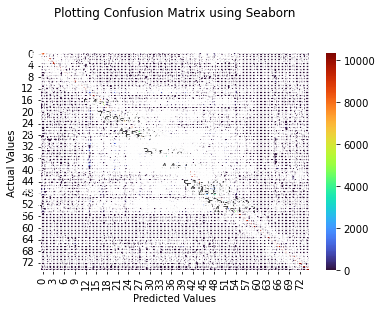

In [34]:
import pandas as pd
file_in = "/home/cyberlab/git/file-detector/output/file_type_cnn_4k_1_dense2_model_CNN/file_type_cnn_4k_1_dense2_model_CNN.in.csv"
df = pd.read_csv(file_in,sep=",")
from sklearn.metrics import classification_report
label = df[["label"]].values
pred = df[["predicted"]].values
target_names = ["jpg", "arw", "cr2", "dng", "gpr", "nef", "nrw", "orf", "pef", "raf", "rw2", "3fr", "tiff", "heic", "bmp", "gif", "png", "ai", "eps", "psd", "mov", "mp4", "3gp", "avi", "mkv", "ogv", "webm", "apk", "jar", "msi", "dmg", "7z", "bz2", "deb", "gz", "pkg", "rar", "rpm", "xz", "zip", "exe", "mach-o", "elf", "dll", "doc", "docx", "key", "ppt", "pptx", "xls", "xlsx", "djvu", "epub", "mobi", "pdf", "md", "rtf", "txt", "tex", "json", "html", "xml", "log", "csv", "aiff", "flac", "m4a", "mp3", "ogg", "wav", "wma", "pcap", "ttf", "dwg", "sqlite"]
print(classification_report(label, pred, target_names=target_names))
import seaborn as sebrn
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as atlas

label = df[["label"]].values
pred = df[["predicted"]].values
target_names1 = []
for i in range(0,75):
    target_names1.append(i)
conf_matrix = (confusion_matrix(label, pred, labels=target_names1))

# Using Seaborn heatmap to create the plot
fx = sebrn.heatmap(conf_matrix, annot=True, cmap='turbo')

# labels the title and x, y axis of plot
fx.set_title('Plotting Confusion Matrix using Seaborn\n\n');
fx.set_xlabel('Predicted Values')
fx.set_ylabel('Actual Values ');
target_names = ["jpg", "arw", "cr2", "dng", "gpr", "nef", "nrw", "orf", "pef", "raf", "rw2", "3fr", "tiff", "heic", "bmp", "gif", "png", "ai", "eps", "psd", "mov", "mp4", "3gp", "avi", "mkv", "ogv", "webm", "apk", "jar", "msi", "dmg", "7z", "bz2", "deb", "gz", "pkg", "rar", "rpm", "xz", "zip", "exe", "mach-o", "elf", "dll", "doc", "docx", "key", "ppt", "pptx", "xls", "xlsx", "djvu", "epub", "mobi", "pdf", "md", "rtf", "txt", "tex", "json", "html", "xml", "log", "csv", "aiff", "flac", "m4a", "mp3", "ogg", "wav", "wma", "pcap", "ttf", "dwg", "sqlite"]

# labels the boxes
fx.xaxis.set_ticklabels(target_names)
fx.yaxis.set_ticklabels(target_names)

atlas.show()

## Checking rlu

              precision    recall  f1-score   support

         jpg       0.92      0.92      0.92     10260
         arw       0.99      0.99      0.99     10204
         cr2       0.94      0.97      0.95     10328
         dng       0.98      0.96      0.97     10206
         gpr       1.00      1.00      1.00     10155
         nef       0.98      0.98      0.98     10444
         nrw       0.99      0.99      0.99     10459
         orf       0.96      0.97      0.97     10143
         pef       0.99      0.99      0.99     10263
         raf       0.96      0.96      0.96     10303
         rw2       0.98      0.98      0.98     10264
         3fr       1.00      1.00      1.00     10250
        tiff       0.98      0.99      0.99     10132
        heic       0.11      0.12      0.12     10308
         bmp       1.00      0.96      0.98     10289
         gif       0.98      0.99      0.98     10289
         png       0.89      0.85      0.87     10376
          ai       0.70    

ValueError: The number of FixedLocator locations (25), usually from a call to set_ticks, does not match the number of ticklabels (75).

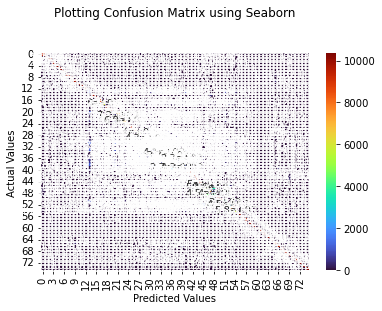

In [35]:
import pandas as pd
file_in = "/home/cyberlab/git/file-detector/output/file_type_cnn_4k_1_leakyrelu_model_CNN/file_type_cnn_4k_1_leakyrelu_model_CNN.in.csv"
df = pd.read_csv(file_in,sep=",")
from sklearn.metrics import classification_report
label = df[["label"]].values
pred = df[["predicted"]].values
target_names = ["jpg", "arw", "cr2", "dng", "gpr", "nef", "nrw", "orf", "pef", "raf", "rw2", "3fr", "tiff", "heic", "bmp", "gif", "png", "ai", "eps", "psd", "mov", "mp4", "3gp", "avi", "mkv", "ogv", "webm", "apk", "jar", "msi", "dmg", "7z", "bz2", "deb", "gz", "pkg", "rar", "rpm", "xz", "zip", "exe", "mach-o", "elf", "dll", "doc", "docx", "key", "ppt", "pptx", "xls", "xlsx", "djvu", "epub", "mobi", "pdf", "md", "rtf", "txt", "tex", "json", "html", "xml", "log", "csv", "aiff", "flac", "m4a", "mp3", "ogg", "wav", "wma", "pcap", "ttf", "dwg", "sqlite"]
print(classification_report(label, pred, target_names=target_names))
import seaborn as sebrn
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as atlas

label = df[["label"]].values
pred = df[["predicted"]].values
target_names1 = []
for i in range(0,75):
    target_names1.append(i)
conf_matrix = (confusion_matrix(label, pred, labels=target_names1))

# Using Seaborn heatmap to create the plot
fx = sebrn.heatmap(conf_matrix, annot=True, cmap='turbo')

# labels the title and x, y axis of plot
fx.set_title('Plotting Confusion Matrix using Seaborn\n\n');
fx.set_xlabel('Predicted Values')
fx.set_ylabel('Actual Values ');
target_names = ["jpg", "arw", "cr2", "dng", "gpr", "nef", "nrw", "orf", "pef", "raf", "rw2", "3fr", "tiff", "heic", "bmp", "gif", "png", "ai", "eps", "psd", "mov", "mp4", "3gp", "avi", "mkv", "ogv", "webm", "apk", "jar", "msi", "dmg", "7z", "bz2", "deb", "gz", "pkg", "rar", "rpm", "xz", "zip", "exe", "mach-o", "elf", "dll", "doc", "docx", "key", "ppt", "pptx", "xls", "xlsx", "djvu", "epub", "mobi", "pdf", "md", "rtf", "txt", "tex", "json", "html", "xml", "log", "csv", "aiff", "flac", "m4a", "mp3", "ogg", "wav", "wma", "pcap", "ttf", "dwg", "sqlite"]

# labels the boxes
fx.xaxis.set_ticklabels(target_names)
fx.yaxis.set_ticklabels(target_names)

atlas.show()

## Checking 512 dense 2

              precision    recall  f1-score   support

         jpg       0.73      0.73      0.73     10182
         arw       0.98      0.98      0.98     10302
         cr2       0.84      0.82      0.83     10174
         dng       0.67      0.66      0.66     10202
         gpr       0.99      0.99      0.99     10166
         nef       0.89      0.88      0.88     10321
         nrw       0.95      0.96      0.96     10285
         orf       0.81      0.80      0.80     10302
         pef       0.92      0.92      0.92     10178
         raf       0.99      0.99      0.99     10201
         rw2       0.70      0.96      0.81     10339
         3fr       1.00      1.00      1.00     10114
        tiff       0.92      0.92      0.92     10165
        heic       0.06      0.06      0.06     10195
         bmp       0.99      0.78      0.87     10316
         gif       0.90      0.89      0.90     10302
         png       0.56      0.55      0.55     10056
          ai       0.22    

ValueError: The number of FixedLocator locations (25), usually from a call to set_ticks, does not match the number of ticklabels (75).

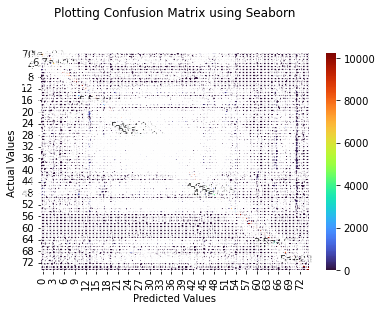

In [38]:
import pandas as pd
file_in = "/home/cyberlab/git/file-detector/output/file_type_cnn_512_1_dense2_model_CNN/file_type_cnn_512_1_dense2_model_CNN.in.csv"

df = pd.read_csv(file_in,sep=",")
from sklearn.metrics import classification_report
label = df[["label"]].values
pred = df[["predicted"]].values
target_names = ["jpg", "arw", "cr2", "dng", "gpr", "nef", "nrw", "orf", "pef", "raf", "rw2", "3fr", "tiff", "heic", "bmp", "gif", "png", "ai", "eps", "psd", "mov", "mp4", "3gp", "avi", "mkv", "ogv", "webm", "apk", "jar", "msi", "dmg", "7z", "bz2", "deb", "gz", "pkg", "rar", "rpm", "xz", "zip", "exe", "mach-o", "elf", "dll", "doc", "docx", "key", "ppt", "pptx", "xls", "xlsx", "djvu", "epub", "mobi", "pdf", "md", "rtf", "txt", "tex", "json", "html", "xml", "log", "csv", "aiff", "flac", "m4a", "mp3", "ogg", "wav", "wma", "pcap", "ttf", "dwg", "sqlite"]
print(classification_report(label, pred, target_names=target_names))
import seaborn as sebrn
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as atlas

label = df[["label"]].values
pred = df[["predicted"]].values
target_names1 = []
for i in range(0,75):
    target_names1.append(i)
conf_matrix = (confusion_matrix(label, pred, labels=target_names1))

# Using Seaborn heatmap to create the plot
fx = sebrn.heatmap(conf_matrix, annot=True, cmap='turbo')

# labels the title and x, y axis of plot
fx.set_title('Plotting Confusion Matrix using Seaborn\n\n');
fx.set_xlabel('Predicted Values')
fx.set_ylabel('Actual Values ');
target_names = ["jpg", "arw", "cr2", "dng", "gpr", "nef", "nrw", "orf", "pef", "raf", "rw2", "3fr", "tiff", "heic", "bmp", "gif", "png", "ai", "eps", "psd", "mov", "mp4", "3gp", "avi", "mkv", "ogv", "webm", "apk", "jar", "msi", "dmg", "7z", "bz2", "deb", "gz", "pkg", "rar", "rpm", "xz", "zip", "exe", "mach-o", "elf", "dll", "doc", "docx", "key", "ppt", "pptx", "xls", "xlsx", "djvu", "epub", "mobi", "pdf", "md", "rtf", "txt", "tex", "json", "html", "xml", "log", "csv", "aiff", "flac", "m4a", "mp3", "ogg", "wav", "wma", "pcap", "ttf", "dwg", "sqlite"]

# labels the boxes
fx.xaxis.set_ticklabels(target_names)
fx.yaxis.set_ticklabels(target_names)

atlas.show()

              precision    recall  f1-score   support

         jpg       0.73      0.75      0.74     10182
         arw       0.98      0.98      0.98     10302
         cr2       0.79      0.80      0.80     10174
         dng       0.58      0.58      0.58     10202
         gpr       0.99      0.99      0.99     10166
         nef       0.88      0.88      0.88     10321
         nrw       0.96      0.96      0.96     10285
         orf       0.75      0.73      0.74     10302
         pef       0.85      0.87      0.86     10178
         raf       0.99      0.99      0.99     10201
         rw2       0.97      0.96      0.96     10339
         3fr       1.00      1.00      1.00     10114
        tiff       0.88      0.84      0.86     10165
        heic       0.06      0.07      0.06     10195
         bmp       0.74      1.00      0.85     10316
         gif       0.84      0.80      0.82     10302
         png       0.52      0.43      0.47     10056
          ai       0.25    

ValueError: The number of FixedLocator locations (25), usually from a call to set_ticks, does not match the number of ticklabels (75).

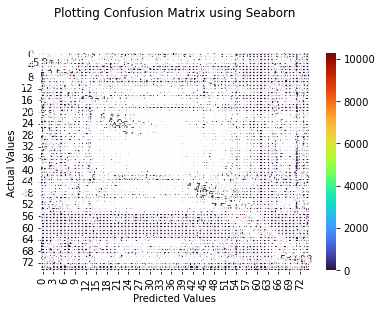

In [39]:
import pandas as pd
file_in = "/home/cyberlab/git/file-detector/output/file_type_cnn_512_1_dense1_model_CNN/file_type_cnn_512_1_dense1_model_CNN.in.csv"

df = pd.read_csv(file_in,sep=",")
from sklearn.metrics import classification_report
label = df[["label"]].values
pred = df[["predicted"]].values
target_names = ["jpg", "arw", "cr2", "dng", "gpr", "nef", "nrw", "orf", "pef", "raf", "rw2", "3fr", "tiff", "heic", "bmp", "gif", "png", "ai", "eps", "psd", "mov", "mp4", "3gp", "avi", "mkv", "ogv", "webm", "apk", "jar", "msi", "dmg", "7z", "bz2", "deb", "gz", "pkg", "rar", "rpm", "xz", "zip", "exe", "mach-o", "elf", "dll", "doc", "docx", "key", "ppt", "pptx", "xls", "xlsx", "djvu", "epub", "mobi", "pdf", "md", "rtf", "txt", "tex", "json", "html", "xml", "log", "csv", "aiff", "flac", "m4a", "mp3", "ogg", "wav", "wma", "pcap", "ttf", "dwg", "sqlite"]
print(classification_report(label, pred, target_names=target_names))
import seaborn as sebrn
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as atlas

label = df[["label"]].values
pred = df[["predicted"]].values
target_names1 = []
for i in range(0,75):
    target_names1.append(i)
conf_matrix = (confusion_matrix(label, pred, labels=target_names1))

# Using Seaborn heatmap to create the plot
fx = sebrn.heatmap(conf_matrix, annot=True, cmap='turbo')

# labels the title and x, y axis of plot
fx.set_title('Plotting Confusion Matrix using Seaborn\n\n');
fx.set_xlabel('Predicted Values')
fx.set_ylabel('Actual Values ');
target_names = ["jpg", "arw", "cr2", "dng", "gpr", "nef", "nrw", "orf", "pef", "raf", "rw2", "3fr", "tiff", "heic", "bmp", "gif", "png", "ai", "eps", "psd", "mov", "mp4", "3gp", "avi", "mkv", "ogv", "webm", "apk", "jar", "msi", "dmg", "7z", "bz2", "deb", "gz", "pkg", "rar", "rpm", "xz", "zip", "exe", "mach-o", "elf", "dll", "doc", "docx", "key", "ppt", "pptx", "xls", "xlsx", "djvu", "epub", "mobi", "pdf", "md", "rtf", "txt", "tex", "json", "html", "xml", "log", "csv", "aiff", "flac", "m4a", "mp3", "ogg", "wav", "wma", "pcap", "ttf", "dwg", "sqlite"]

# labels the boxes
fx.xaxis.set_ticklabels(target_names)
fx.yaxis.set_ticklabels(target_names)

atlas.show()

## Checking 512 leakyrlu

              precision    recall  f1-score   support

         jpg       0.73      0.75      0.74     10182
         arw       0.98      0.98      0.98     10302
         cr2       0.61      0.81      0.70     10174
         dng       0.61      0.61      0.61     10202
         gpr       0.99      0.99      0.99     10166
         nef       0.88      0.89      0.88     10321
         nrw       0.96      0.96      0.96     10285
         orf       0.77      0.74      0.76     10302
         pef       0.86      0.89      0.88     10178
         raf       0.99      0.99      0.99     10201
         rw2       0.96      0.96      0.96     10339
         3fr       1.00      1.00      1.00     10114
        tiff       0.90      0.84      0.87     10165
        heic       0.06      0.08      0.07     10195
         bmp       0.96      0.82      0.88     10316
         gif       0.86      0.81      0.83     10302
         png       0.52      0.44      0.48     10056
          ai       0.26    

ValueError: The number of FixedLocator locations (25), usually from a call to set_ticks, does not match the number of ticklabels (75).

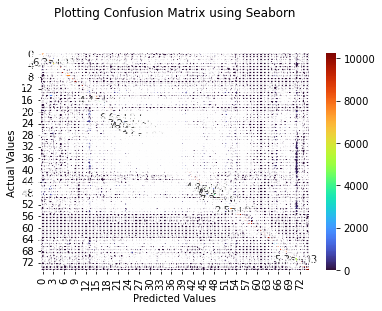

In [40]:
import pandas as pd
file_in = "/home/cyberlab/git/file-detector/output/file_type_cnn_512_1_leakyrelu2_model_CNN/file_type_cnn_512_1_leakyrelu2_model_CNN.in.csv"

df = pd.read_csv(file_in,sep=",")
from sklearn.metrics import classification_report
label = df[["label"]].values
pred = df[["predicted"]].values
target_names = ["jpg", "arw", "cr2", "dng", "gpr", "nef", "nrw", "orf", "pef", "raf", "rw2", "3fr", "tiff", "heic", "bmp", "gif", "png", "ai", "eps", "psd", "mov", "mp4", "3gp", "avi", "mkv", "ogv", "webm", "apk", "jar", "msi", "dmg", "7z", "bz2", "deb", "gz", "pkg", "rar", "rpm", "xz", "zip", "exe", "mach-o", "elf", "dll", "doc", "docx", "key", "ppt", "pptx", "xls", "xlsx", "djvu", "epub", "mobi", "pdf", "md", "rtf", "txt", "tex", "json", "html", "xml", "log", "csv", "aiff", "flac", "m4a", "mp3", "ogg", "wav", "wma", "pcap", "ttf", "dwg", "sqlite"]
print(classification_report(label, pred, target_names=target_names))
import seaborn as sebrn
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as atlas

label = df[["label"]].values
pred = df[["predicted"]].values
target_names1 = []
for i in range(0,75):
    target_names1.append(i)
conf_matrix = (confusion_matrix(label, pred, labels=target_names1))

# Using Seaborn heatmap to create the plot
fx = sebrn.heatmap(conf_matrix, annot=True, cmap='turbo')

# labels the title and x, y axis of plot
fx.set_title('Plotting Confusion Matrix using Seaborn\n\n');
fx.set_xlabel('Predicted Values')
fx.set_ylabel('Actual Values ');
target_names = ["jpg", "arw", "cr2", "dng", "gpr", "nef", "nrw", "orf", "pef", "raf", "rw2", "3fr", "tiff", "heic", "bmp", "gif", "png", "ai", "eps", "psd", "mov", "mp4", "3gp", "avi", "mkv", "ogv", "webm", "apk", "jar", "msi", "dmg", "7z", "bz2", "deb", "gz", "pkg", "rar", "rpm", "xz", "zip", "exe", "mach-o", "elf", "dll", "doc", "docx", "key", "ppt", "pptx", "xls", "xlsx", "djvu", "epub", "mobi", "pdf", "md", "rtf", "txt", "tex", "json", "html", "xml", "log", "csv", "aiff", "flac", "m4a", "mp3", "ogg", "wav", "wma", "pcap", "ttf", "dwg", "sqlite"]

# labels the boxes
fx.xaxis.set_ticklabels(target_names)
fx.yaxis.set_ticklabels(target_names)

atlas.show()